In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [6]:
from pathlib import Path
import time
import yaml

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import pytorch_lightning as pl
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms

from src.data import PlethoraDataModule
from src.data.preprocess import *
from src.models.unet import UNet
from src.visualization import plot_batch, plot_true_vs_pred
from src.metrics import dice_coeff_vectorized

In [7]:
device = "cuda:0"
ckpt_path = "logs/unet-plethora-512/version_1/ckpts/epoch=9-dice_coeff_val=0.947.ckpt"
net = UNet.load_from_checkpoint(ckpt_path)
net.to(device).eval();
                                
data_params_path = str(Path(ckpt_path).parents[1] / "data_hparams.yaml")
with open(data_params_path, "r") as f:
    data_module_args = yaml.safe_load(f)
                                
dm = PlethoraDataModule(**data_module_args)        
dm.setup()
print(len(dm.train_ds), len(dm.val_ds), len(dm.test_ds))

33032 10002 5199


In [60]:
small_ds = Subset(dm.test_ds, [60, 90, 179, 310])
test_loader = DataLoader(small_ds, batch_size=4, shuffle=False, pin_memory=True)
batch = next(iter(test_loader))
X, y = batch['img'], batch['mask']
with torch.no_grad():
    logits = net(X.to(device))
    pred_masks = torch.argmax(logits, dim=1)

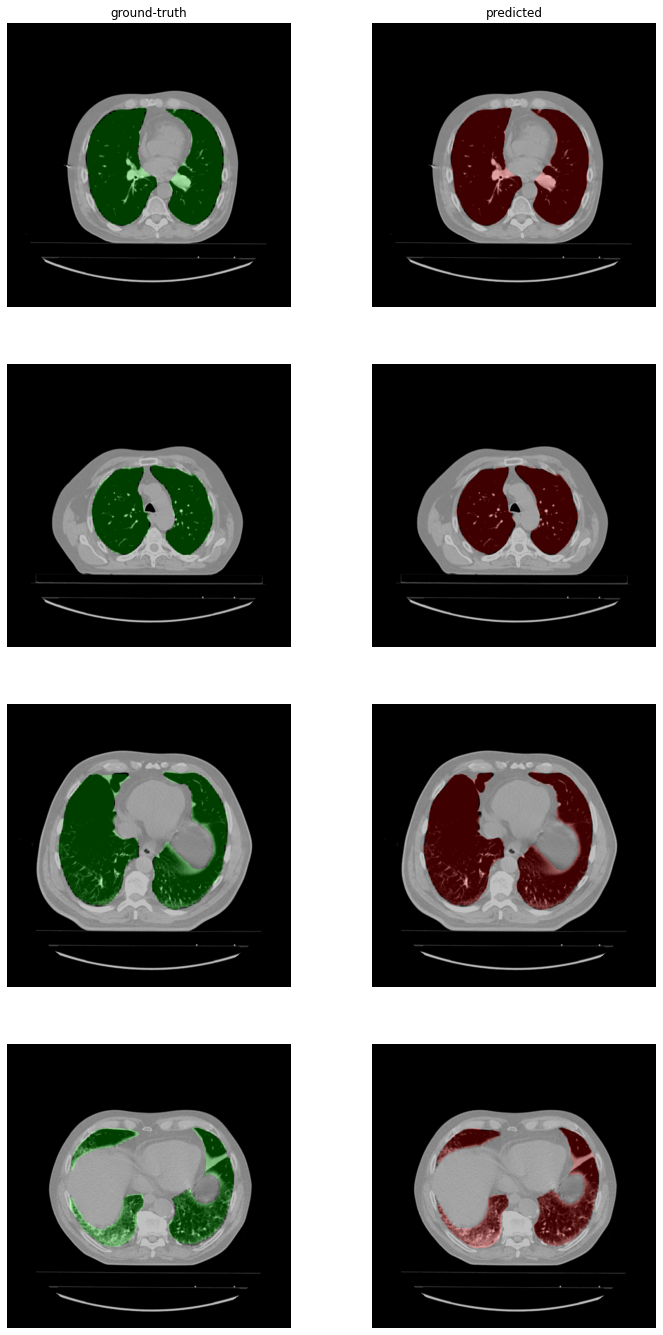

In [66]:
plot_true_vs_pred(X, y, pred_masks,
                  mask_alpha=0.25,
                  figsize=(12, 6))

In [19]:
dice_scores = []
# evaluate on test set
for batch in tqdm(dm.test_dataloader()):
    X, y = batch["img"], batch["mask"]
    X, y = X.to(dckpt_pathe), y.to(device)
    with torch.no_grad():
        logits = net(X.to(device))
        pred_masks = torch.argmax(logits, dim=1)
        dice_scores.append(dice_coeff_vectorized(pred_masks, y, reduce_fn=None))
dice_scores = torch.cat(dice_scores)

100%|██████████| 325/325 [12:07<00:00,  2.24s/it]


In [60]:
print("dsc mean:", dice_scores.mean().item())

worst_idxs = torch.argsort(dice_scores, descending=False).cpu()
worst_idxs = worst_idxs[:100].numpy()
worst_idxs = np.random.choice(worst_idxs, size=10, replace=False)
dice_scores[worst_idxs]

dsc mean: 0.946585476398468


tensor([1.7817e-01, 5.6497e-07, 2.5932e-01, 3.9370e-07, 1.2346e-06, 4.1502e-01,
        5.0000e-06, 2.6316e-06, 4.0000e-06, 2.4119e-01], device='cuda:0')

In [66]:
# resort idxs based on DSC
worst_idxs = worst_idxs[torch.argsort(dice_scores[worst_idxs]).cpu().numpy()]
worst_scores = dice_scores[worst_idxs].cpu().numpy()
worst_scores

array([3.9370062e-07, 5.6497140e-07, 1.2345664e-06, 2.6315720e-06,
       3.9999841e-06, 4.9999749e-06, 1.7817390e-01, 2.4118946e-01,
       2.5931939e-01, 4.1501990e-01], dtype=float32)

In [ ]:
worst_subset = Subset(dm.test_ds, worst_idxs)
worst_loader = DataLoader(worst_subset, batch_size=10, shuffle=True)

it = iter(worst_loader)
for _ in range(1):
    sample = next(it)
X_test, y_test = sample["img"], sample["mask"]
with torch.no_grad():
    preds = net(X_test.to(device))
    pred_masks = torch.argmax(preds, dim=1)
    pred_masks = pred_masks.cpu()

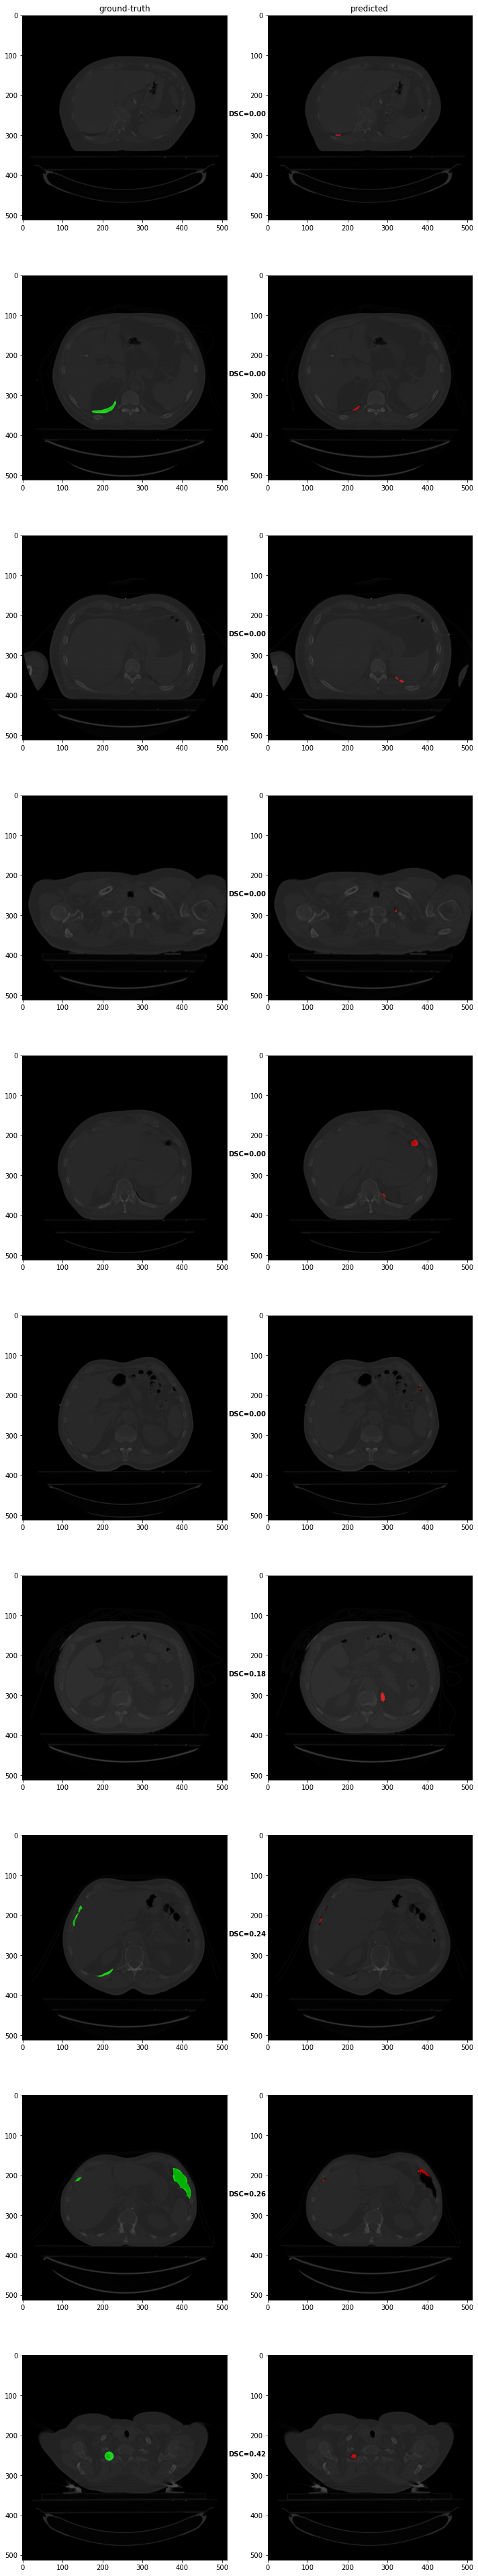

In [104]:
subplot_labels = [f"DSC={dsc:.2f}" for dsc in worst_scores]
plot_true_vs_pred(X_test, y_test, pred_masks,
                  mask_alpha=0.7,
                  figsize=(12, 7),
                  subplot_labels=subplot_labels)